<a href="https://colab.research.google.com/github/BabarMuaz/skinDiseaseDetection/blob/main/FineTunning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy data to colab dir
!cp -rf /content/drive/MyDrive/Splitted_SuperCleanedDataset_70_20_10 /content

# to remove this folder
#%rm -rf Splitted_SuperCleanedDataset_70_20_10 

In [ ]:
# imporitng required libraries

#general
import itertools
import numpy as np # it is confusion matrix and classification function dependency 
import matplotlib.pyplot as plt #  it is training plots func dependency

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # to save model and early stopping
from tensorflow.keras.metrics import categorical_crossentropy # loss function
from tensorflow.keras import layers # used when model is build Sequentially
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data processing function
from tensorflow.keras.optimizers import Adam # optimizer
# sklearn
from sklearn.metrics import classification_report,confusion_matrix # to generate confusion matrix and classification summary

In [ ]:
# get paths to fetch data
train_path = "/content/Splitted_SuperCleanedDataset_70_20_10/train"
valid_path = "/content/Splitted_SuperCleanedDataset_70_20_10/val"
test_path = "/content/Splitted_SuperCleanedDataset_70_20_10/test"

In [ ]:
# Create Data Batches for training
size = 224

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
                                         directory=train_path, 
                                         target_size=(size,size),  
                                         batch_size=3904,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
                                         directory=valid_path, target_size=(size,size),
                                         batch_size=1088,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
                                         directory=test_path, 
                                         target_size=(size,size), 
                                         batch_size=564,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

Found 3904 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [ ]:
# checking how classes are labelled, somestimes depending on the server folders are stored alphabatelly or not
print("training data labelled as = ",train_batches.class_indices)
print("validation data labelled as = ",valid_batches.class_indices)
print("testing data labelled as = ",test_batches.class_indices)

training data labelled as =  {'melanoma': 0, 'nevus': 1}
validation data labelled as =  {'melanoma': 0, 'nevus': 1}
testing data labelled as =  {'melanoma': 0, 'nevus': 1}


In [ ]:
(x_train, y_train) = next(train_batches)  # creating one batch for training images, purpose is to put data on ram faster execution

In [ ]:
(x_test, y_test) = next(valid_batches)  # creating one batch for validation images, purpose is to put data on ram faster execution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

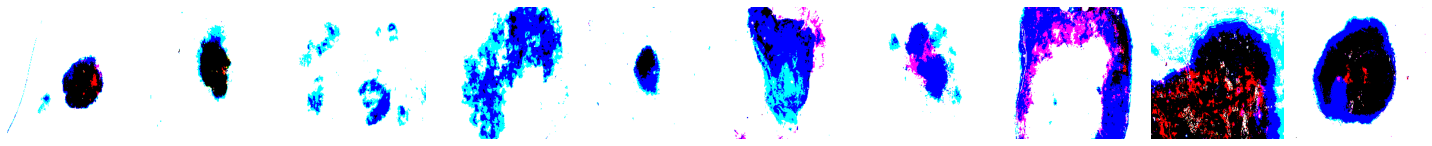

[0. 0. 0. ... 1. 1. 1.]


In [ ]:
# function to see images in Datagen, this is used to see images after preprocessing step
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(x_train)
print(y_train)

In [ ]:
# above ImageDataGenerator function along with next is used to put data on ram
# when data is on ram training is very quick, CAUTION: only do this if your dataset can fit on ram
# if dataaugmentation, than apply here
# datagen = ImageDataGenerator(rotation_range=20,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       vertical_flip=True,
#       fill_mode='nearest')  # data in batches is fed to model using this 

datagen = ImageDataGenerator()      


In [ ]:
# Create a base Densenet model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(size, size,3))
base_model.trainable = False
#training=False

# Create new model on top
inputs = tf.keras.Input(shape=(size, size, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(512)(x)
# x = tf.keras.layers.Dropout(0.1)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(128)(x)
# x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()




58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable p

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)


initial_epochs = 20

# train model
history = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    steps_per_epoch=x_train.shape[0]//10,
                    epochs = initial_epochs , 
                    validation_data = (x_test, y_test))

Epoch 1/20
390/390 [==============================] - 28s 44ms/step - loss: 0.8145 - binary_accuracy: 0.6908 - val_loss: 0.4545 - val_binary_accuracy: 0.8180
Epoch 2/20
390/390 [==============================] - 15s 40ms/step - loss: 0.4574 - binary_accuracy: 0.8102 - val_loss: 0.3835 - val_binary_accuracy: 0.8456
Epoch 3/20
390/390 [==============================] - 16s 40ms/step - loss: 0.3917 - binary_accuracy: 0.8341 - val_loss: 0.3633 - val_binary_accuracy: 0.8465
Epoch 4/20
390/390 [==============================] - 16s 40ms/step - loss: 0.3733 - binary_accuracy: 0.8387 - val_loss: 0.3574 - val_binary_accuracy: 0.8594
Epoch 5/20
390/390 [==============================] - 16s 40ms/step - loss: 0.3626 - binary_accuracy: 0.8416 - val_loss: 0.3670 - val_binary_accuracy: 0.8493
Epoch 6/20
390/390 [==============================] - 15s 40ms/step - loss: 0.3571 - binary_accuracy: 0.8439 - val_loss: 0.3456 - val_binary_accuracy: 0.8640
Epoch 7/20
390/390 [==============================] 

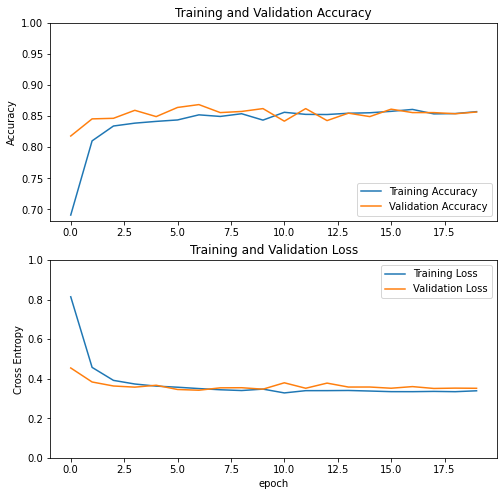

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
#model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)


#create callback
filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    steps_per_epoch=x_train.shape[0]//10,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data = (x_test, y_test),
                    callbacks = callbacks)

Epoch 20/30
390/390 [==============================] - ETA: 0s - loss: 0.3397 - binary_accuracy: 0.8552
Epoch 20: val_loss improved from inf to 0.34202, saving model to best_model.hdf5
390/390 [==============================] - 40s 98ms/step - loss: 0.3397 - binary_accuracy: 0.8552 - val_loss: 0.3420 - val_binary_accuracy: 0.8585
Epoch 21/30
390/390 [==============================] - ETA: 0s - loss: 0.2549 - binary_accuracy: 0.8878
Epoch 21: val_loss improved from 0.34202 to 0.33031, saving model to best_model.hdf5
390/390 [==============================] - 37s 95ms/step - loss: 0.2549 - binary_accuracy: 0.8878 - val_loss: 0.3303 - val_binary_accuracy: 0.8759
Epoch 22/30
390/390 [==============================] - ETA: 0s - loss: 0.2054 - binary_accuracy: 0.9101
Epoch 22: val_loss improved from 0.33031 to 0.29398, saving model to best_model.hdf5
390/390 [==============================] - 37s 95ms/step - loss: 0.2054 - binary_accuracy: 0.9101 - val_loss: 0.2940 - val_binary_accuracy: 0.8

In [ ]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

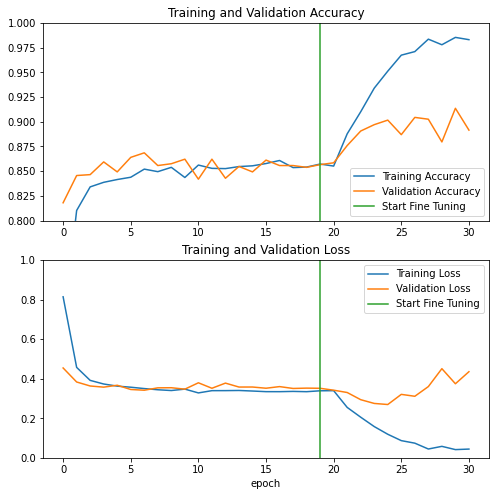

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# get testing data
(img, label) = next(test_batches)  # creating one batch for testing images, purpose is to put data on ram faster execution

In [ ]:
model = tf.keras.models.load_model('best_model.hdf5')

In [ ]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

In [ ]:
# print classification sumamry
#predict_x=model.predict(img) 
#predictions=np.argmax(predict_x,axis=1)
#predictions = predictions.reshape(1,-1)[0]
#label=np.argmax(label,axis=1)
#label = label.reshape(1,-1)[0]
print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.88      0.90      0.89       282
       nevus       0.90      0.87      0.88       282

    accuracy                           0.89       564
   macro avg       0.89      0.89      0.89       564
weighted avg       0.89      0.89      0.89       564



In [ ]:
# This function is used to create Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[254  28]
 [ 36 246]]


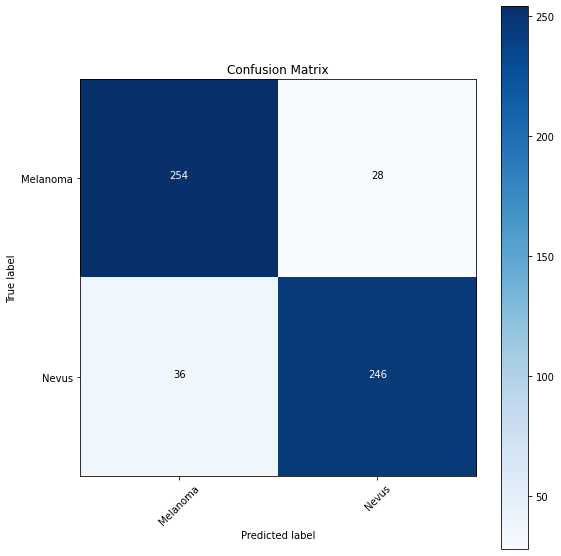

In [ ]:
# calling confsion matrix function

cm_aug = confusion_matrix(label, a)
plot_confusion_matrix(cm_aug, classes = ['Melanoma','Nevus'], title='Confusion Matrix', normalize=False)